In [62]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from chart_studio import plotly as py
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from itertools import product

from datetime import datetime, timedelta

rcParams['figure.figsize'] = 11, 9

print(os.listdir("../Datasets"))

['.gitkeep', 'AAPL.csv', 'aapl.us.txt', 'Google_Stock_Price_Train.csv', 'SPY.csv']


In [63]:
from yahoofinancials import YahooFinancials
from joblib import Memory

TMPDIR = '/tmp'
memory = Memory(TMPDIR, verbose=0)

In [64]:
@memory.cache
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']] 

In [65]:
"""
ticker = 'SPY'
yahoo_financials = YahooFinancials(ticker)
historicalData = yahoo_financials.get_historical_price_data('2008-09-15', '2018-09-15', 'daily')
historicalData
"""

"\nticker = 'SPY'\nyahoo_financials = YahooFinancials(ticker)\nhistoricalData = yahoo_financials.get_historical_price_data('2008-09-15', '2018-09-15', 'daily')\nhistoricalData\n"

In [66]:
%%time
apple = pd.read_csv('../Datasets/SPY.csv', index_col='Date', parse_dates=['Date'])
apple = apple['2017':'2019']

apple['Name'] = 'AAPL'
apple.head()

Wall time: 16 ms


Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03  225.039993  225.830002  223.880005  225.240005  206.147537   
2017-01-04  225.619995  226.750000  225.610001  226.580002  207.373947   
2017-01-05  226.270004  226.580002  225.479996  226.399994  207.209183   
2017-01-06  226.529999  227.750000  225.899994  227.210007  207.950562   
2017-01-09  226.910004  227.070007  226.419998  226.460007  207.264114   

              Volume  Name  
Date                        
2017-01-03  91366500  AAPL  
2017-01-04  78744400  AAPL  
2017-01-05  78379000  AAPL  
2017-01-06  71559900  AAPL  
2017-01-09  46939700  AAPL

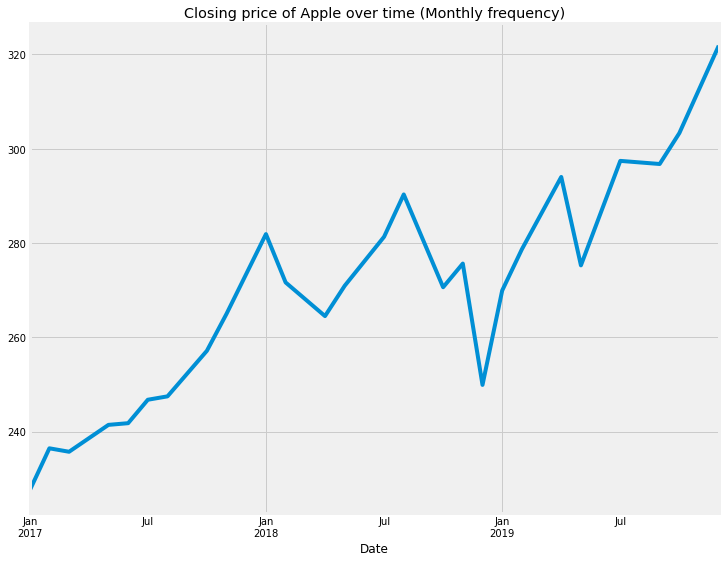

In [67]:
apple["Close"].asfreq('M').interpolate().plot() # asfreq method is used to convert a time series to a specified frequency. 
                                                 # Here it is monthly frequency. Also using interpolate() to fix the gaps between the timeseries
plt.title('Closing price of Apple over time (Monthly frequency)')
plt.show()

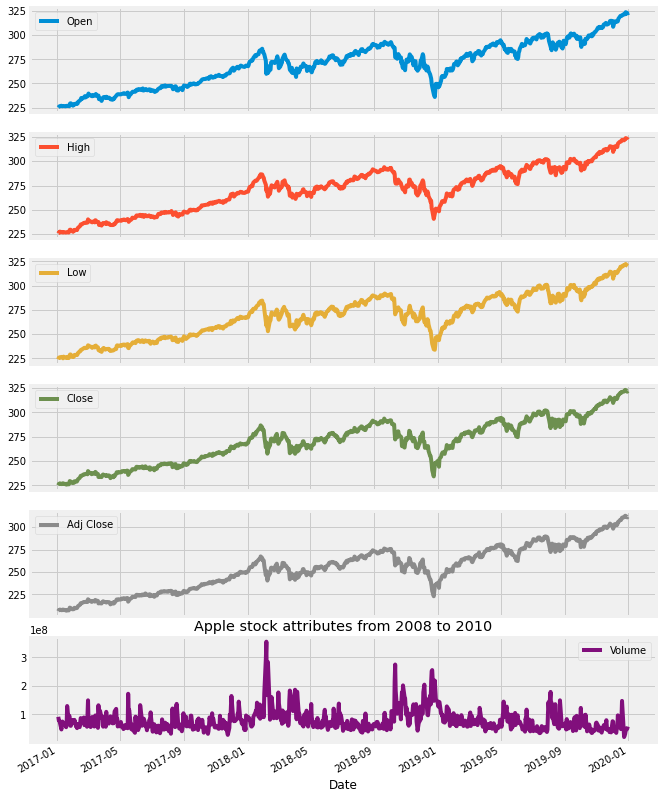

In [68]:
apple['2000':'2020'].plot(subplots=True, figsize=(10,15))
plt.title('Apple stock attributes from 2008 to 2010')
plt.savefig('Apple.png')
plt.show()

In [69]:
"""
timestamp = pd.Timestamp(2017, 1, 1, 12)
period = pd.Period('2017-01-01')
period.start_time < timestamp < period.end_time
new_period = timestamp.to_period(freq='H')
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp
"""

"\ntimestamp = pd.Timestamp(2017, 1, 1, 12)\nperiod = pd.Period('2017-01-01')\nperiod.start_time < timestamp < period.end_time\nnew_period = timestamp.to_period(freq='H')\nnew_timestamp = period.to_timestamp(freq='H', how='start')\nnew_timestamp\n"

In [70]:
"""
apple.shape
apple_resampled = apple.resample('3D').mean()
apple_resampled.head()
apple_resampled.shape
"""


"\napple.shape\napple_resampled = apple.resample('3D').mean()\napple_resampled.head()\napple_resampled.shape\n"

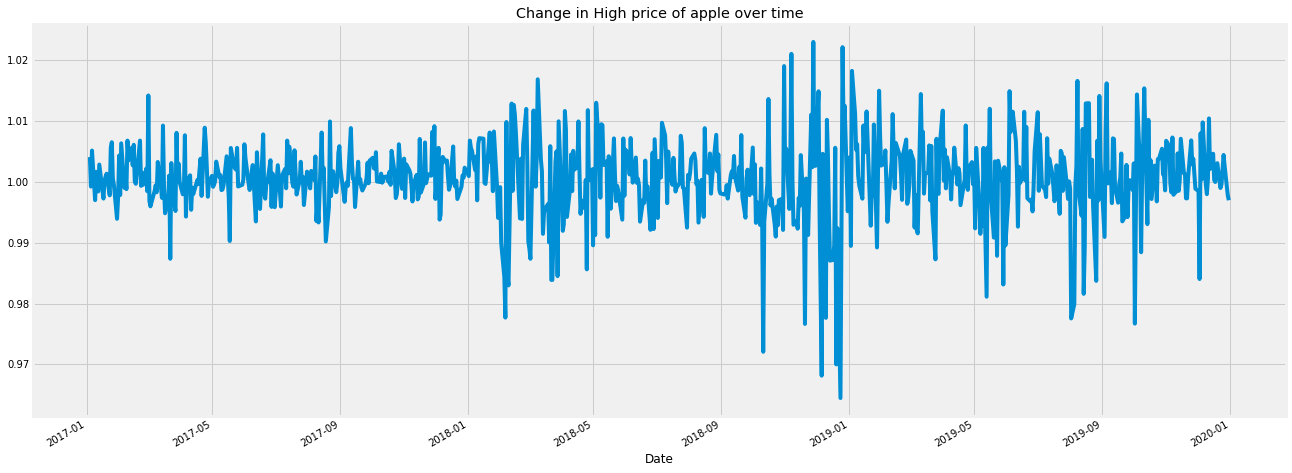

In [71]:
apple['Change'] = apple.High.div(apple.High.shift())
apple['Change'].plot(figsize=(20,8))
_ = plt.title('Change in High price of apple over time')

Decomposing closing price of Apple over time


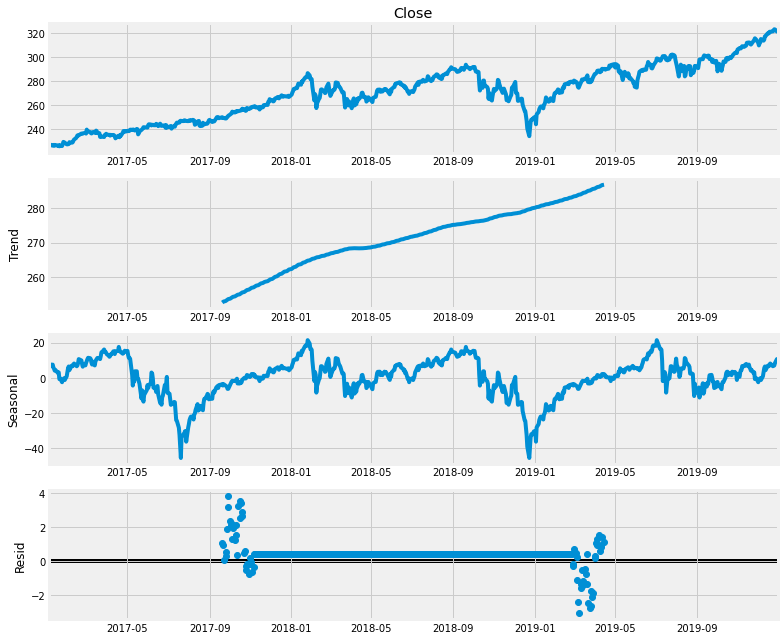

In [72]:
# Now, for decomposition...
print('Decomposing closing price of Apple over time')
decomposed_apple_close = sm.tsa.seasonal_decompose(apple["Close"],freq=360) # The frequncy is annual
figure = decomposed_apple_close.plot()
plt.show()

In [73]:
"""
# Predicting the close price of Apple stock 
rcParams['figure.figsize'] = 16, 6
model = ARIMA(apple["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=600, end=1000)
_ = plt.title('ARIMA model: predicting Close price of Apple stock')
plt.show()
"""

'\n# Predicting the close price of Apple stock \nrcParams[\'figure.figsize\'] = 16, 6\nmodel = ARIMA(apple["Close"].diff().iloc[1:].values, order=(2,1,0))\nresult = model.fit()\nprint(result.summary())\nresult.plot_predict(start=600, end=1000)\n_ = plt.title(\'ARIMA model: predicting Close price of Apple stock\')\nplt.show()\n'

In [74]:
"""
rmse = math.sqrt(mean_squared_error(apple["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))
"""

'\nrmse = math.sqrt(mean_squared_error(apple["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))\nprint("The root mean squared error is {}.".format(rmse))\n'

In [75]:
"""
# Predicting the Apple stock volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(apple["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Volume of Apple stock')
plt.show()
"""

'\n# Predicting the Apple stock volume\nrcParams[\'figure.figsize\'] = 16, 6\nmodel = ARIMA(apple["Volume"].diff().iloc[1:].values, order=(2,1,0))\nresult = model.fit()\nprint(result.summary())\nresult.plot_predict(start=700, end=1000)\n_ = plt.title(\'ARIMA model: predicting Volume of Apple stock\')\nplt.show()\n'

In [76]:
"""
rmse = math.sqrt(mean_squared_error(apple["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))
"""

'\nrmse = math.sqrt(mean_squared_error(apple["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))\nprint("The root mean squared error is {}.".format(rmse))\n'

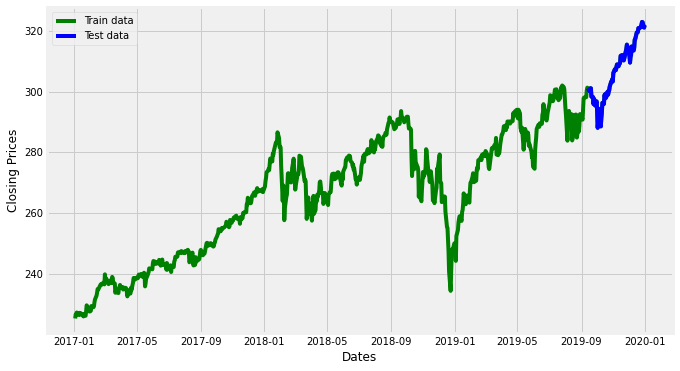

In [77]:
df_log = apple["Close"]
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3007.328, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3008.641, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3008.584, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3006.940, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3003.074, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3000.518, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3009.515, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3002.305, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3005.079, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3000.747, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3008.688, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3007.040, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3000.341, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3002.623, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]          

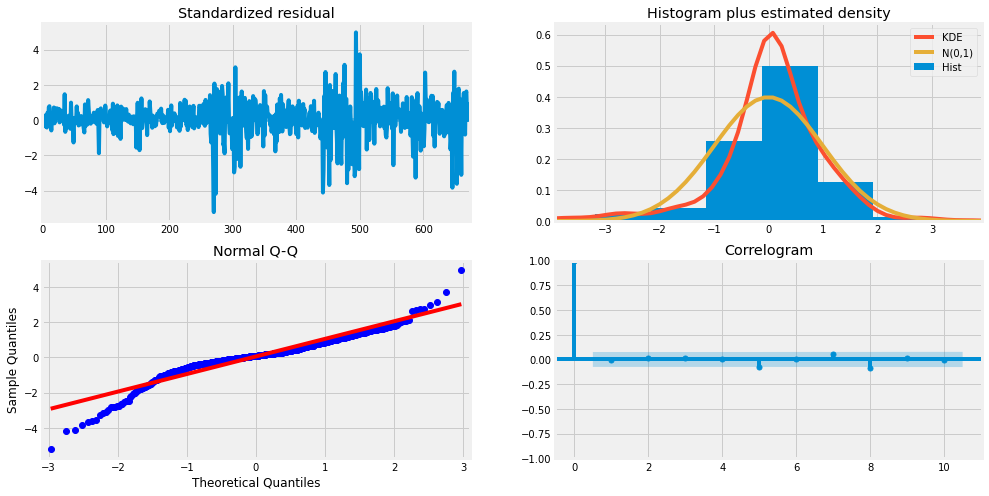

In [78]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [79]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(2,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  674
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1495.259
Method:                       css-mle   S.D. of innovations              2.224
Date:                Thu, 27 Jan 2022   AIC                           3000.518
Time:                        14:21:20   BIC                           3023.085
Sample:                             1   HQIC                          3009.257
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1100      0.081      1.353      0.176      -0.049       0.269
ar.L1.D.Close    -0.9328      0.051    -18.174      0.000      -1.033      -0.832
ar.L2.D.Close    -0.0847      0.039     

In [82]:
fc, se, conf = fitted.forecast(76, alpha=0.05)  # 95% conf

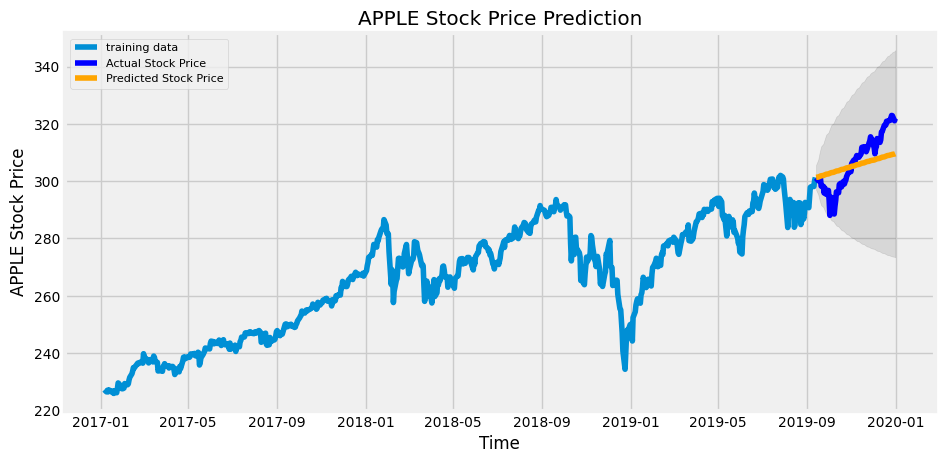

last predicted price 309.576094706175
last actual price 321.859985


In [84]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


print("last predicted price", fc[len(fc)-1])
print("last actual price", test_data[len(test_data)-1])

In [30]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 52.65617331081592
MAE: 6.120555537533488
RMSE: 7.256457352649151
MAPE: 0.019923809791411846


Dickey–Fuller test: p=0.813528


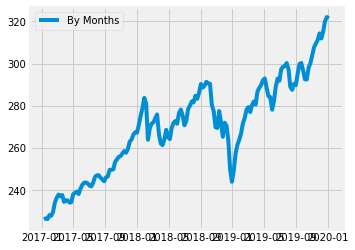

<Figure size 1080x504 with 0 Axes>

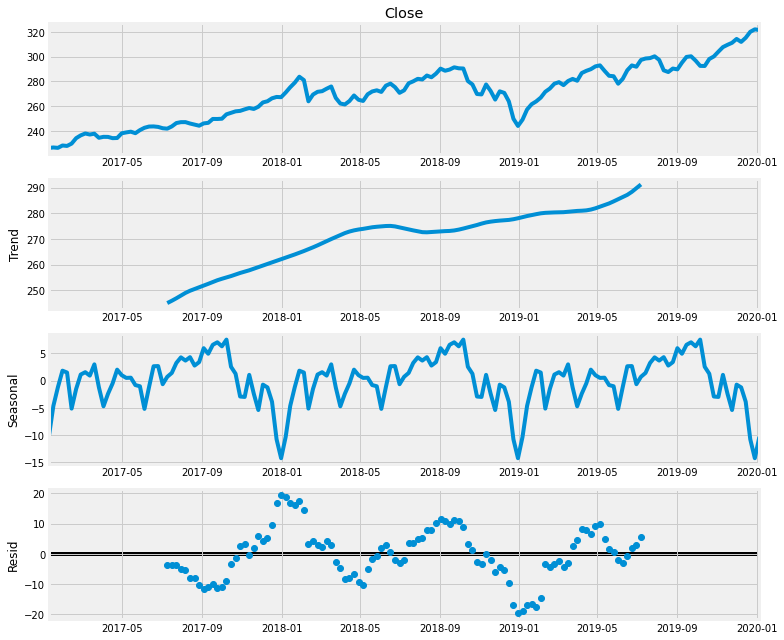

In [43]:
# ANOTHER ARIMA METHOD BY MONTHS
df_month = apple.resample('W').mean()
plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

In [44]:
# Box-Cox Transformations
df_month['Close_box'], lmbda = stats.boxcox(df_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])

Dickey–Fuller test: p=0.813528


In [45]:
# Seasonal differentiation
df_month['close_box_diff'] = df_month.Close_box - df_month.Close_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.close_box_diff[12:])[1])

Dickey–Fuller test: p=0.012546


Dickey–Fuller test: p=0.000033


<Figure size 1080x504 with 0 Axes>

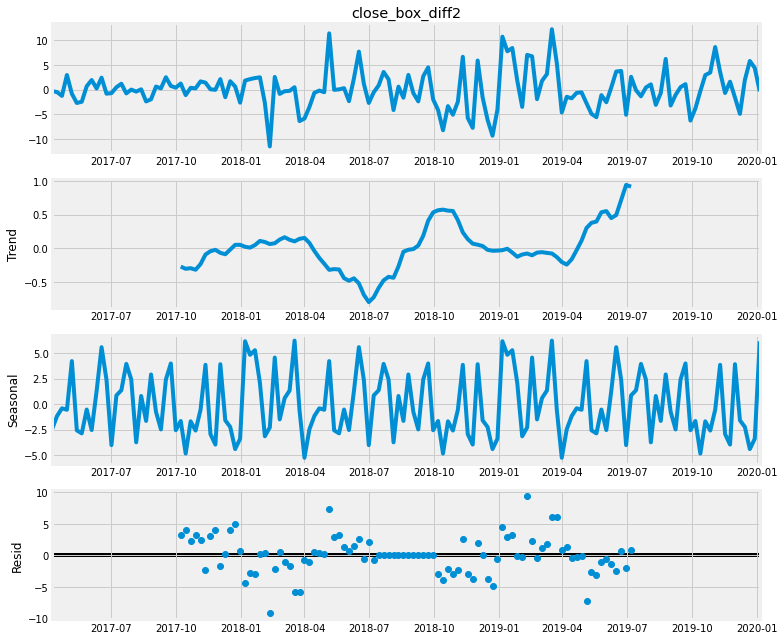

In [46]:
# Regular differentiation
df_month['close_box_diff2'] = df_month.close_box_diff - df_month.close_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.close_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.close_box_diff2[13:])[1])

plt.show()

In [47]:
print(df_month['Close_box'].shape)
df_month['Close'].shape

(157,)


(157,)

In [48]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [49]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Close_box   No. Observations:                  157
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -355.253
Date:                            Thu, 27 Jan 2022   AIC                            716.506
Time:                                    14:14:47   BIC                            725.415
Sample:                                01-08-2017   HQIC                           720.126
                                     - 01-05-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3313      0.066      5.029      0.000       0.202       0.460
ma.S.L12      -0.9980      6.362   

In [50]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    

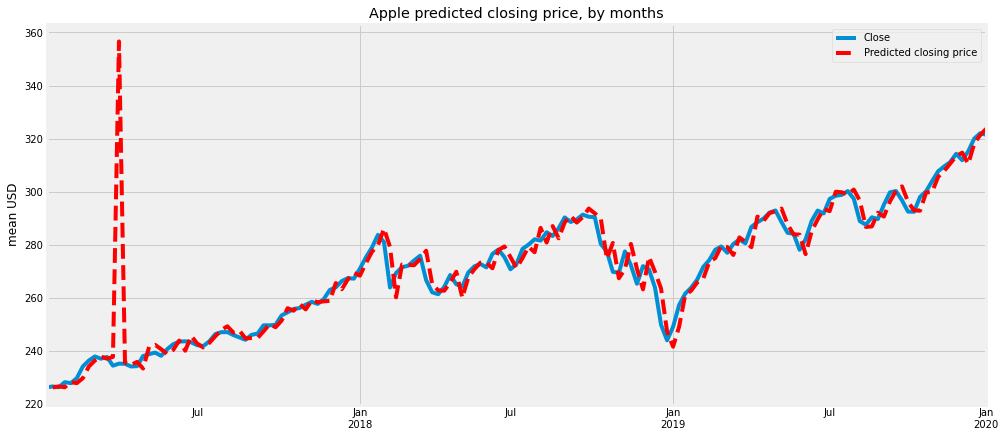

In [57]:
# Prediction
df_month2 = df_month[['Close']]
"""
date_list = [datetime(2020, 2, 5), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28), datetime(2018, 2, 20), datetime(2021, 3, 1)]
"""
date_list = []
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=1, end=200), lmbda)
plt.figure(figsize=(15,7))
df_month2.Close.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted closing price')
plt.legend()
plt.title('Apple predicted closing price, by months')
plt.ylabel('mean USD')
plt.show()

In [58]:
fc = df_month2.forecast
test_data = df_month2.Close
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').